# Example: Human segmentation with TransUnet and transfer learning from ImageNet-trained VGG16 model

In [36]:
import numpy as np
from glob import glob
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import load_model
from keras_unet_collection import models, utils
from sklearn.metrics import f1_score, jaccard_score

In [28]:
# !pip install tensorflow-gpu==2.5.0

In [5]:
#!pip install keras-unet-collection

  Using cached keras_unet_collection-0.1.11-py3-none-any.whl (67 kB)


This example requires `keras-unet-collection`:
```
pip install keras-unet-collection
```

In [37]:
print(tf.__version__)

2.5.0


In [38]:
# the indicator of a fresh run
FIRST_TIME_RUNNING = False

# user-specified working directory
FILE_PATH = 'dataset/'
FILE_PATH_LABEL = 'dataset/'

## The Monuseg dataset

The dataset for this challenge was obtained by carefully annotating tissue images of several patients with tumors of different organs and who were diagnosed at multiple hospitals. This dataset was created by downloading H&E stained tissue images captured at 40x magnification from TCGA archive. 

H&E staining is a routine protocol to enhance the contrast of a tissue section and is commonly used for tumor assessment (grading, staging, etc.). 

Given the diversity of nuclei appearances across multiple organs and patients, and the richness of staining protocols adopted at multiple hospitals, the training dataset will enable the development of robust and generalizable nuclei segmentation techniques that will work right out of the box.

In [39]:
# train files path
path_train_img = FILE_PATH + 'train folder/img/'
path_train_mask = FILE_PATH_LABEL + 'train folder/mask/'

# validation file path
path_valid_img = FILE_PATH + 'validation folder/img/'
path_valid_mask = FILE_PATH_LABEL + 'validation folder/mask/'

# test files path
path_test_img = FILE_PATH + 'test folder/img/'
path_test_mask = FILE_PATH_LABEL + 'test folder/mask/'

# predict files path
path_predict_mask = FILE_PATH + 'predict folder/'


In [40]:
train_input_names = np.array(sorted(glob(path_train_img+'*.png')))
train_label_names = np.array(sorted(glob(path_train_mask+'*.png')))
# flag_human = split_human_samples(train_label_names, human_id=0)
# train_input_names = train_input_names[flag_human]
# train_label_names = train_label_names[flag_human]

In [41]:
test_input_names = np.array(sorted(glob(path_test_img+'*.png')))
test_label_names = np.array(sorted(glob(path_test_mask+'*.png')))
# flag_human_test = split_human_samples(test_label_names, human_id=0)
# test_input_names = test_input_names[flag_human_test]
# test_label_names = test_label_names[flag_human_test]

In [42]:
# get valid files name
valid_input_names = np.array(sorted(glob(path_valid_img+'*.png')))
valid_label_names = np.array(sorted(glob(path_valid_mask+'*.png')))

In [43]:
# get predict file names
predict_label_names = np.array(sorted(glob(path_predict_mask+'*.png')))

### Exploratory data analysis

In [44]:
def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [45]:
I_MAX = 10   # explore 10 images
input_example = utils.image_to_array(train_input_names[:I_MAX], size=128, channel=3)
label_example = utils.image_to_array(train_label_names[:I_MAX], size=128, channel=1)

Text(0.5, 1.0, 'Segmentation mask')

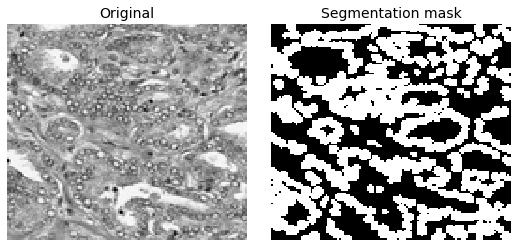

In [46]:
i_example = 2

fig, AX = plt.subplots(1, 2, figsize=(7, 3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)

for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(input_example[i_example, ...], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(label_example[i_example, ..., 0] > 0, cmap=plt.cm.gray)
AX[0].set_title("Original", fontsize=14)
AX[1].set_title("Segmentation mask", fontsize=14)

## Attention U-net with an ImageNet-trained backbone

Attention U-net is applied for this segmentation task. This architecture is modified from the conventionally used U-net by assigning attention gates on each upsampling level. 

Attention gates take upsampled (i.e., decoded) and downsampled (i.e., encoded) tensors as queries and keys, respectively. These queries and keys are mapped to intermediate channel sizes and fed into the additive attention learning. The resulting vector is rescaled by a sigmoid function and multiplied with the downsampled tensor (keys, but here treated as "values" of self-attention). The attention gate output replaces the downsampled tensor and is concatenated with the upsampled tensor.

Based on the amount and complexity of COCO samples, ImageNet-trained VGG16 is applied as an encoder backbone. This transfer learning strategy is expected to improve the segmentation performance based on two reasons: 

 * The ImageNet and COCO containts (somewhat) similar kinds of natural images with a high overlap of data distribution; 

 * The VGG16 architecture is a combination of same-padding convolution and max-pooling kernels, capable of extracting hierarchical features that can be processed by attention gates (ResNet backbone contains zero padding layers and is suboptimal in this case).

The code cell below configures the attention U-net with an ImageNet-trained VGG16 backbone. Hyper-parameters are explained through the Python helper function:

```python
from keras_unet_collection import models

help(models.att_unet_2d)
```

In [47]:


model = models.att_unet_2d((128, 128, 3), filter_num=[64, 128, 256, 512, 1024], n_labels=2,
                           stack_num_down=2, stack_num_up=2, activation='ReLU',
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid',
                           batch_norm=True, pool=False, unpool=False,
                           backbone='VGG16', weights='imagenet',
                           freeze_backbone=True, freeze_batch_norm=True,
                           name='attunet')


C:\Users\MCSP_Lab\Documents\GitHub\TransUnetPlusPlus\keras_unet_collection\_backbone_zoo.py:45: UserWarning: 

Backbone VGG16 does not use batch norm, but other layers received batch_norm=True
  warnings.warn(param_mismatch);


In [23]:
'''
model = models.transunet_2d((128, 128, 3), filter_num=[64, 128, 256, 512], n_labels=2, stack_num_down=2, stack_num_up=2,
                                embed_dim=768, num_mlp=3072, num_heads=12, num_transformer=12,
                                activation='ReLU', mlp_activation='GELU', output_activation='Softmax',
                                batch_norm=True, pool=True, unpool='bilinear', name='transunet')
'''

In [13]:
'''
model = models.unet_2d((None, None, 3), [64, 128, 256, 512, 1024], n_labels=2,
                      stack_num_down=2, stack_num_up=1,
                      activation='GELU', output_activation='Softmax',
                      batch_norm=True, pool='max', unpool='nearest', name='unet')
'''

In [24]:
'''
model = models.swin_unet_2d((128, 128, 3), filter_num_begin=64, n_labels=2, depth=4, stack_num_down=2, stack_num_up=2,
                            patch_size=(2, 2), num_heads=[4, 8, 8, 8], window_size=[4, 2, 2, 2], num_mlp=512,
                            output_activation='Softmax', shift_window=True, name='swin_unet')

'''

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


The second layer of the configured model, i.e., right after an input layer, is expected to be the VGG16 backbone.

In [48]:
model.layers[1].name

'VGG16_backbone'

For simplicity, this segmentation model is trained with cross-entropy loss with SGD optimizer and a learning rate of 1E-2.

In [49]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.SGD(lr=1e-2), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Create Keras metric

## Training

The segmentation model is trained with 200 epoches with early stopping. Each epoch contains 100 batches and each batch contains 32 samples.

*The training process here is far from systematic, and is provided for illustration purposes only.*

In [50]:
L = len(train_input_names)
ind_all = utils.shuffle_ind(L)

L_train = int(0.9*L) 
L_valid = L - L_train
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:]

In [51]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def target_data_process(target_array):
    '''Converting human, non-human pixels into two categories.'''
    target_array[target_array > 0] = 1  # grouping all other non-human categories 
    return keras.utils.to_categorical(target_array, num_classes=2)

In [52]:
valid_input = input_data_process(utils.image_to_array(valid_input_names, size=128, channel=3))
valid_label = target_data_process(utils.image_to_array(valid_label_names, size=128, channel=1))

In [53]:
N_EPOCH = 400  # number of epoches
N_BATCH = 100  # number of batches per epoch
N_SAMPLE = 32  # number of samples per batch

tol = 0  # current early stopping patience
max_tol = 2  # the max-allowed early stopping patience
min_del = 0  # the lowest acceptable loss value reduction 

# loop over epoches
for epoch in range(N_EPOCH):
    # initial loss record
    if epoch == 0:
        y_pred = model.predict([valid_input])
        record = np.mean(keras.losses.binary_crossentropy(valid_label, y_pred))
        print('\tInitial loss = {}'.format(record))
    # loop over batches
    for step in range(N_BATCH):
        # selecting smaples for the current batch
        ind_train_shuffle = utils.shuffle_ind(L_train)[:N_SAMPLE]
        # batch data formation
        # augmentation is not applied
        train_input = input_data_process(utils.image_to_array(train_input_names[ind_train_shuffle], size=128, channel=3))
        train_label = target_data_process(utils.image_to_array(train_label_names[ind_train_shuffle], size=128, channel=1))
        # train on batch
        loss_ = model.train_on_batch([train_input,], [train_label,])
        # ** training loss is not stored ** #
    # epoch-end validation
    print('Epoch = ', epoch)
    y_pred = model.predict([valid_input])
    record_temp = np.mean(keras.losses.binary_crossentropy(valid_label, y_pred))
    # ** validation loss is not stored ** #
    # if loss is reduced

    if record - record_temp > min_del:
        print('Validation performance is improved from {} to {}'.format(record, record_temp))
        record = record_temp  # update the loss record
        tol = 0  # refresh early stopping patience
        # ** model checkpoint is not stored ** #
    # if loss not reduced
    else:
        print('Validation performance {} is NOT improved'.format(record_temp))
        tol += 1
        if tol >= max_tol:
            print('Early stopping')
            break
        else:
            # Pass to the next epoch
            continue

	Initial loss = 1.178726077079773
Epoch =  0
Validation performance is improved from 1.178726077079773 to 0.4469504952430725
Epoch =  1
Validation performance is improved from 0.4469504952430725 to 0.4020988941192627
Epoch =  2
Validation performance is improved from 0.4020988941192627 to 0.39442411065101624
Epoch =  3
Validation performance is improved from 0.39442411065101624 to 0.3851029574871063
Epoch =  4
Validation performance is improved from 0.3851029574871063 to 0.3781238794326782
Epoch =  5
Validation performance is improved from 0.3781238794326782 to 0.37229031324386597
Epoch =  6
Validation performance is improved from 0.37229031324386597 to 0.3675061762332916
Epoch =  7
Validation performance is improved from 0.3675061762332916 to 0.36364489793777466
Epoch =  8
Validation performance is improved from 0.36364489793777466 to 0.360572874546051
Epoch =  9
Validation performance is improved from 0.360572874546051 to 0.35816287994384766
Epoch =  10
Validation performance is impr

In [54]:
model.save('attention-unet')

C:\Users\MCSP_Lab\anaconda3\envs\SwinUnetPlusPlus\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: attention-unet\assets


## Evaluation

The testing set performance is evaluated with cross-entropy and example outputs.

In [55]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [56]:
model = load_model('attention-unet')

In [57]:
test_input = input_data_process(utils.image_to_array(test_input_names, size=128, channel=3))
test_label = target_data_process(utils.image_to_array(test_label_names, size=128, channel=1))

In [58]:
# prediction on test_input without threshold
# y_pred = model.predict([test_input], verbose=1)
y_pred = model.predict(test_input)

# prediction on test_input with threshold
y_pred_t = (y_pred > 0.5).astype(np.uint8)

In [59]:
print('Testing set cross-entropy = {}'.format(np.mean(keras.losses.binary_crossentropy(test_label, y_pred))))

Testing set cross-entropy = 0.4408152103424072


**Example of outputs**

As a common practice in computer vision projects, only nice looking samples are plotted :

Text(0.5, 1.0, 'Labeled truth')

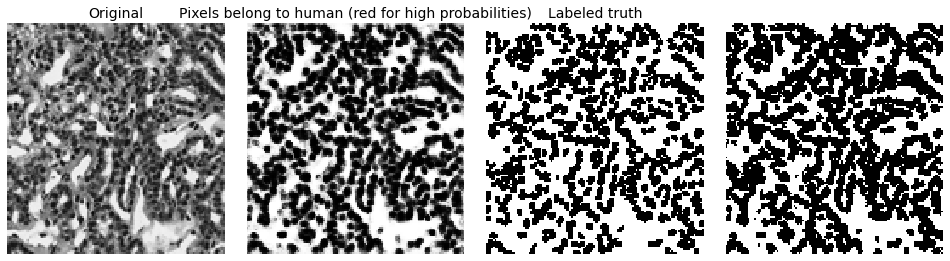

In [60]:
i_sample = 11

fig, AX = plt.subplots(1, 4, figsize=(13, (13-0.2)/4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(test_input[i_sample, ...], axis=-1), cmap=plt.cm.gray)
# AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
# AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.jet)

AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.gray)
AX[2].pcolormesh(test_label[i_sample, ..., 0], cmap=plt.cm.gray)
AX[3].pcolormesh(y_pred_t[i_sample, ..., 0], cmap=plt.cm.gray)

AX[0].set_title("Original", fontsize=14)
AX[1].set_title("Pixels belong to human (red for high probabilities)", fontsize=14)
AX[2].set_title("Labeled truth", fontsize=14)

In [61]:
print(y_pred_t[0, ..., 0].shape)

(128, 128)


In [62]:
Image.fromarray(255*np.array(y_pred_t[11, ..., 0])).resize((128, 128)).save('mask.png')

In [63]:
for i in range(len(y_pred_t)):
    if (i + 1 < 10):
        image_name = '000' + str(i + 1) + '.png'
        Image.fromarray(255*np.array(y_pred_t[i, ..., 0])).save(image_name)
    else:
        image_name = '00' + str(i + 1) + '.png'
        Image.fromarray(255*np.array(y_pred_t[i, ..., 0])).save(image_name)

In [64]:
f1, iou = [], []
for i in range(len(test_input_names)):
    INPUT = np.array(Image.open(test_label_names[i]))
    INPUT = np.where(INPUT >= 127, 1, 0)
    LABEL = np.array(Image.open(predict_label_names[i]))
    LABEL = np.where(LABEL >= 127, 1, 0)
    y_true, y_pred = INPUT.flatten(), LABEL.flatten()
    f1.append(f1_score(y_true, y_pred))
    iou.append(jaccard_score(y_true, y_pred))

In [65]:
np.mean(f1), np.mean(iou)

(0.2715801275880459, 0.15791906229977307)